# Electrical machines seminar, first exercise
## Solving the magnetic vector potential formulation

The goal for the first project is to compute the magnetostatic problem for a "real" world problem.

To this end, we will work with Alessio \& Peter's motor geometry of a permanent magnet machine.



For now, let $\Omega$ denote the computational domain.

Then Maxwell's equations for magnetostatics are described by:

\begin{alignat}{2}
\operatorname{curl} h &= j, \qquad && \text{in } \Omega, \label{eq:1}\\
\operatorname{div} b &= 0, \qquad && \text{in } \Omega, \label{eq:2}\\
n \cdot b &= 0, \qquad && \text{on } \partial\Omega, \label{eq:3}
\end{alignat}

On simply connected domains, the second equation implies the existence of a vector potential $a$ such that

\begin{align}
    \operatorname{curl} a &= b\label{eq:4}
\end{align}

So far, these equations are independent of the materials.

To incorporate material properties, we need to introduce constitutive equations, which will be different depending on the material type, such as air, iron, or magnet.

For now, assume that the magnetic field $h$ and magnetic flux $b$ are linked by

\begin{align}
    h = f'(b) \label{eq:nl}
\end{align}

where $f$ denotes a smooth and strongly convex "energy density" $f: \mathbb{R}^d \to \mathbb{R}$.

Using this relation, we can rewrite the problem in a compact manner in the following way:

\begin{align*}
    \operatorname{curl}(f'(\operatorname{curl} a)) &= j + \operatorname{curl} m \\
    n\cdot \operatorname{curl} a &=0
\end{align*}

In 2D, we can make the following simplifications:

In the typical setting with cylindrical symmetry, which is of relevance for electric motors, one has $\Omega = \Omega_{2D} \times (0,L)$ and assumes that $j=(0,0,j_3)$, $m=(m_1,m_2,0)$, $a=(0,0,a_3)$, $b=(b_1,b_2,0)$, and $h=(h_1,h_2,0)$, with all components independent of $z$.

In this way, one arrives at the scalar problem 

\begin{alignat}{2}
\operatorname{Curl} f'(\operatorname{curl}_{2D} a_3) &= j_3 + \operatorname{Curl}_{2D} m, \qquad && \text{in } \Omega_{2D}, \\
n \cdot \operatorname{curl}_{2D} a_3 &= 0, \qquad && \text{on } \partial\Omega_{2D}.
\end{alignat}

Here $\operatorname{Curl}_{2D}=(-\partial_y, \partial_x)$ and $\operatorname{curl}_{2D}=\binom{\partial_y}{-\partial_x}$ are the vector-to-scalar and scalar-to-vector curl, respectively.

This problem can further be transformed into 

\begin{alignat}{2}
-\operatorname{div} (g'(\nabla u)) &= j_3 + \operatorname{div} m^\perp :=\widehat j_3, \qquad &&\text{in } \Omega_{2D} \label{eq:sys1} \\
u &= 0, \qquad && \text{on } \partial\Omega_{2D} \label{eq:sys2}
\end{alignat}

where now $u=a_3$ is the $z$-component of the vector potential, $\binom{-b_2}{b_1}=\nabla u$ is the rotated magnetic flux, $\binom{-h_2}{h_1}=g'(\nabla u)$ is the rotated magnetic field, and $m^\perp = \binom{-m_2}{m_1}$ is the rotated magnetization.

\medskip

### Herbert's note during our first meeting:
The boundary condition for the transformed problem reads $\partial_t u := t\cdot\nabla u=0$, meaning that the tangential component of $u$ vanishes on the whole boundary. This, in turn, means that $u$ has to be constant on the boundary. For this reason, we may set $u=0$ on $\partial\Omega$. Careful! If the domain is not simply connected, we are not allowed to prescribe $u$ everywhere on the boundary!

Loading imports ...

In [19]:
import sys; sys.path.insert(0,'../../') # adds parent directory
import time
import numpy as np
import pde
import scipy.sparse as sps
from sksparse.cholmod import cholesky as chol
import plotly.io as pio
#pio.renderers.default = 'iframe'
pio.renderers.default = 'png'
import pyamg
import plotly
#plotly.offline.init_notebook_mode()

ORDER = 2

Loading the motor, generating inital mesh

In [20]:
motor_npz = np.load('meshes/motor.npz', allow_pickle = True)

p = motor_npz['p'].T
e = motor_npz['e'].T
t = motor_npz['t'].T
q = np.empty(0)
regions_2d = motor_npz['regions_2d']
regions_1d = motor_npz['regions_1d']
m = motor_npz['m']
j3 = motor_npz['j3']

MESH = pde.mesh(p,e,t,q)
# MESH.refinemesh()
# MESH.refinemesh()

Prepares lists of indices.

In [21]:
mask_air_all = MESH.getIndices2d(regions_2d, 'air')
mask_stator_rotor_and_shaft = MESH.getIndices2d(regions_2d, 'iron')
mask_magnet = MESH.getIndices2d(regions_2d, 'magnet')
mask_coil = MESH.getIndices2d(regions_2d, 'coil')
mask_shaft = MESH.getIndices2d(regions_2d, 'shaft')
mask_iron_rotor = MESH.getIndices2d(regions_2d, 'rotor_iron', exact = 1)
mask_rotor_air = MESH.getIndices2d(regions_2d, 'rotor_air', exact = 1)
mask_air_gap_rotor = MESH.getIndices2d(regions_2d, 'air_gap_rotor', exact = 1)

mask_rotor     = mask_iron_rotor + mask_magnet + mask_rotor_air + mask_shaft
mask_linear    = mask_air_all + mask_magnet + mask_shaft + mask_coil
mask_nonlinear = mask_stator_rotor_and_shaft - mask_shaft

trig_rotor = t[np.where(mask_rotor)[0],0:3]
trig_air_gap_rotor = t[np.where(mask_air_gap_rotor)[0],0:3]
points_rotor = np.unique(trig_rotor)


ind_stator_outer = np.flatnonzero(np.core.defchararray.find(list(regions_1d),'stator_outer')!=-1)
ind_rotor_outer = np.flatnonzero(np.core.defchararray.find(list(regions_1d),'rotor_outer')!=-1)
ind_edges_rotor_outer = np.where(np.isin(e[:,2],ind_rotor_outer))[0]
edges_rotor_outer = e[ind_edges_rotor_outer,0:2]

ind_trig_coils   = MESH.getIndices2d(regions_2d, 'coil', return_index = True)[0]
ind_trig_magnets = MESH.getIndices2d(regions_2d, 'magnet', return_index = True)[0]

R = lambda x: np.array([[np.cos(x),-np.sin(x)],
                        [np.sin(x), np.cos(x)]])

r1 = p[edges_rotor_outer[0,0],0]
a1 = 2*np.pi/edges_rotor_outer.shape[0]

Setting up the function $f$ and its derivatives

In [22]:
k1 = 49.4; k2 = 1.46; k3 = 520.6; nu0 = 10**7/(4*np.pi)
# k1 = 3.8; k2 = 2.17; k3 = 396.2
    
f_iron = lambda x,y : k1/(2*k2)*(np.exp(k2*(x**2+y**2))-1) + 1/2*k3*(x**2+y**2) # magnetic energy density in iron

nu = lambda x,y : k1*np.exp(k2*(x**2+y**2))+k3
nux = lambda x,y : 2*x*k1*k2*np.exp(k2*(x**2+y**2))
nuy = lambda x,y : 2*y*k1*k2*np.exp(k2*(x**2+y**2))

fx_iron = lambda x,y : nu(x,y)*x
fy_iron = lambda x,y : nu(x,y)*y
fxx_iron = lambda x,y : nu(x,y) + x*nux(x,y)
fxy_iron = lambda x,y : x*nuy(x,y)
fyx_iron = lambda x,y : y*nux(x,y)
fyy_iron = lambda x,y : nu(x,y) + y*nuy(x,y)

f_linear = lambda x,y : 1/2*nu0*(x**2+y**2)
fx_linear = lambda x,y : nu0*x
fy_linear = lambda x,y : nu0*y
fxx_linear = lambda x,y : nu0 + 0*x
fxy_linear = lambda x,y : x*0
fyx_linear = lambda x,y : y*0
fyy_linear = lambda x,y : nu0 + 0*y


f   = lambda ux,uy :   f_linear(ux,uy)*new_mask_linear +   f_iron(ux,uy)*new_mask_nonlinear
fx  = lambda ux,uy :  fx_linear(ux,uy)*new_mask_linear +  fx_iron(ux,uy)*new_mask_nonlinear
fy  = lambda ux,uy :  fy_linear(ux,uy)*new_mask_linear +  fy_iron(ux,uy)*new_mask_nonlinear
fxx = lambda ux,uy : fxx_linear(ux,uy)*new_mask_linear + fxx_iron(ux,uy)*new_mask_nonlinear
fxy = lambda ux,uy : fxy_linear(ux,uy)*new_mask_linear + fxy_iron(ux,uy)*new_mask_nonlinear
fyx = lambda ux,uy : fyx_linear(ux,uy)*new_mask_linear + fyx_iron(ux,uy)*new_mask_nonlinear
fyy = lambda ux,uy : fyy_linear(ux,uy)*new_mask_linear + fyy_iron(ux,uy)*new_mask_nonlinear

Setting first or second order variables, expanding mask for second order, as $f$ has to be evaluated for $P_1$, where the gradiant of our solution lies

In [23]:
if ORDER == 1:
    poly = 'P1'
    dxpoly = 'P0'
    order_phiphi = 2
    order_dphidphi = 0
    new_mask_linear = mask_linear
    new_mask_nonlinear = mask_nonlinear
    u = np.zeros(MESH.np)
    
if ORDER == 2:
    poly = 'P2'
    dxpoly = 'P1'
    order_phiphi = 4
    order_dphidphi = 2
    new_mask_linear = np.tile(mask_linear,(3,1)).T.flatten()
    new_mask_nonlinear = np.tile(mask_nonlinear,(3,1)).T.flatten()
    u = np.zeros(MESH.np + MESH.NoEdges)

Assembling the matrix and right-hand sides

In [24]:
tm = time.monotonic()
    
phi_H1  = pde.h1.assemble(MESH, space = poly, matrix = 'M', order = order_phiphi)
dphix_H1, dphiy_H1 = pde.h1.assemble(MESH, space = poly, matrix = 'K', order = order_dphidphi)
dphix_H1_o0, dphiy_H1_o0 = pde.h1.assemble(MESH, space = poly, matrix = 'K', order = 0)
dphix_H1_o1, dphiy_H1_o1 = pde.h1.assemble(MESH, space = poly, matrix = 'K', order = 1)
dphix_H1_order_phiphi, dphiy_H1_order_phiphi = pde.h1.assemble(MESH, space = poly, matrix = 'K', order = order_phiphi)
phi_H1b = pde.h1.assembleB(MESH, space = poly, matrix = 'M', shape = phi_H1.shape, order = order_phiphi)
phi_L2 = pde.l2.assemble(MESH, space = dxpoly, matrix = 'M', order = order_dphidphi)


D_order_dphidphi = pde.int.assemble(MESH, order = order_dphidphi)
D_order_phiphi = pde.int.assemble(MESH, order = order_phiphi)
D_order_phiphi_b = pde.int.assembleB(MESH, order = order_phiphi)


Kxx = dphix_H1 @ D_order_dphidphi @ dphix_H1.T
Kyy = dphiy_H1 @ D_order_dphidphi @ dphiy_H1.T
Cx = phi_L2 @ D_order_dphidphi @ dphix_H1.T
Cy = phi_L2 @ D_order_dphidphi @ dphiy_H1.T

D_stator_outer = pde.int.evaluateB(MESH, order = order_phiphi, edges = ind_stator_outer)
B_stator_outer = phi_H1b@ D_stator_outer @ phi_H1b.T

penalty = 1e10

J = 0; # J0 = 0
for i in range(48):
    J += pde.int.evaluate(MESH, order = order_phiphi, coeff = lambda x,y : j3[i], regions = np.r_[ind_trig_coils[i]]).diagonal()
    # J0+= pde.int.evaluate(MESH, order = 0, coeff = lambda x,y : j3[i], regions = np.r_[ind_trig_coils[i]]).diagonal()
J = 0*J

M0 = 0; M1 = 0; M00 = 0
for i in range(16):
    M0 += pde.int.evaluate(MESH, order = order_phiphi, coeff = lambda x,y : m[0,i], regions = np.r_[ind_trig_magnets[i]]).diagonal()
    M1 += pde.int.evaluate(MESH, order = order_phiphi, coeff = lambda x,y : m[1,i], regions = np.r_[ind_trig_magnets[i]]).diagonal()

    # M00 += pde.int.evaluate(MESH, order = 0, coeff = lambda x,y : m_new[0,i], regions = np.r_[ind_trig_magnets[i]]).diagonal()

aJ = phi_H1@ D_order_phiphi @J

aM = dphix_H1_order_phiphi@ D_order_phiphi @(-M1) +\
     dphiy_H1_order_phiphi@ D_order_phiphi @(+M0)

aMnew = aM


# fig = MESH.pdesurf_hybrid(dict(trig = 'P0',quad = 'Q0',controls = 1), M00, u_height=0)
# fig.show()

# print('Assembling + stuff ', time.monotonic()-tm)

TODO

In [25]:
maxIter = 100
epsangle = 1e-5;

angleCondition = np.zeros(5)
eps_newton = 1e-8
factor_residual = 1/2
mu = 0.0001

def gss(u):
    ux = dphix_H1.T@u; uy = dphiy_H1.T@u

    fxx_grad_u_Kxx = dphix_H1 @ D_order_dphidphi @ sps.diags(fxx(ux,uy))@ dphix_H1.T
    fyy_grad_u_Kyy = dphiy_H1 @ D_order_dphidphi @ sps.diags(fyy(ux,uy))@ dphiy_H1.T
    fxy_grad_u_Kxy = dphiy_H1 @ D_order_dphidphi @ sps.diags(fxy(ux,uy))@ dphix_H1.T
    fyx_grad_u_Kyx = dphix_H1 @ D_order_dphidphi @ sps.diags(fyx(ux,uy))@ dphiy_H1.T
    return (fxx_grad_u_Kxx + fyy_grad_u_Kyy + fxy_grad_u_Kxy + fyx_grad_u_Kyx) + penalty*B_stator_outer

def gs(u):    
    ux = dphix_H1.T@u; uy = dphiy_H1.T@u
    return dphix_H1 @ D_order_dphidphi @ fx(ux,uy) + dphiy_H1 @ D_order_dphidphi @ fy(ux,uy) + penalty*B_stator_outer@u - aJ + aM

def J(u):
    ux = dphix_H1.T@u; uy = dphiy_H1.T@u
    return np.ones(D_order_dphidphi.size)@ D_order_dphidphi @f(ux,uy) -(aJ-aM)@u + 1/2*penalty*u@B_stator_outer@u

tm = time.monotonic()
for i in range(maxIter):
    gsu = gs(u)
    gssu = gss(u)
    w = chol(gssu).solve_A(-gsu)

    norm_w = np.linalg.norm(w)
    norm_gsu = np.linalg.norm(gsu)

    if (-(w@gsu)/(norm_w*norm_gsu)<epsangle):
        angleCondition[i%5] = 1
        if np.product(angleCondition)>0:
            w = -gsu
            print("STEP IN NEGATIVE GRADIENT DIRECTION")
    else: angleCondition[i%5]=0

    alpha = 1

    # ResidualLineSearch
    # for k in range(1000):
    #     if np.linalg.norm(gs(u+alpha*w)) <= np.linalg.norm(gs(u)): break
    #     else: alpha = alpha*factor_residual

    # AmijoBacktracking
    float_eps = np.finfo(float).eps
    for kk in range(1000):
        if J(u+alpha*w)-J(u) <= alpha*mu*(gsu@w) + np.abs(J(u))*float_eps: break
        else: alpha = alpha*factor_residual

    u = u + alpha*w

    print ("NEWTON: Iteration: %2d " %(i+1)+"||obj: %2e" %J(u)+"|| ||grad||: %2e" %np.linalg.norm(gs(u))+"||alpha: %2e" % (alpha))

    if(np.linalg.norm(gs(u)) < eps_newton): break

elapsed = time.monotonic()-tm

NEWTON: Iteration:  1 ||obj: -4.127871e+02|| ||grad||: 1.078161e+04||alpha: 2.500000e-01
NEWTON: Iteration:  2 ||obj: -6.400601e+02|| ||grad||: 8.131900e+03||alpha: 2.500000e-01
NEWTON: Iteration:  3 ||obj: -9.068079e+02|| ||grad||: 3.519789e+04||alpha: 1.000000e+00
NEWTON: Iteration:  4 ||obj: -9.119700e+02|| ||grad||: 1.307618e+04||alpha: 1.000000e+00
NEWTON: Iteration:  5 ||obj: -9.137392e+02|| ||grad||: 4.781323e+03||alpha: 1.000000e+00
NEWTON: Iteration:  6 ||obj: -9.142756e+02|| ||grad||: 1.685626e+03||alpha: 1.000000e+00
NEWTON: Iteration:  7 ||obj: -9.144010e+02|| ||grad||: 5.535611e+02||alpha: 1.000000e+00
NEWTON: Iteration:  8 ||obj: -9.144234e+02|| ||grad||: 1.587839e+02||alpha: 1.000000e+00
NEWTON: Iteration:  9 ||obj: -9.144265e+02|| ||grad||: 3.153580e+01||alpha: 1.000000e+00
NEWTON: Iteration: 10 ||obj: -9.144267e+02|| ||grad||: 2.215111e+00||alpha: 1.000000e+00
NEWTON: Iteration: 11 ||obj: -9.144267e+02|| ||grad||: 1.344262e-02||alpha: 1.000000e+00
NEWTON: Iteration: 12

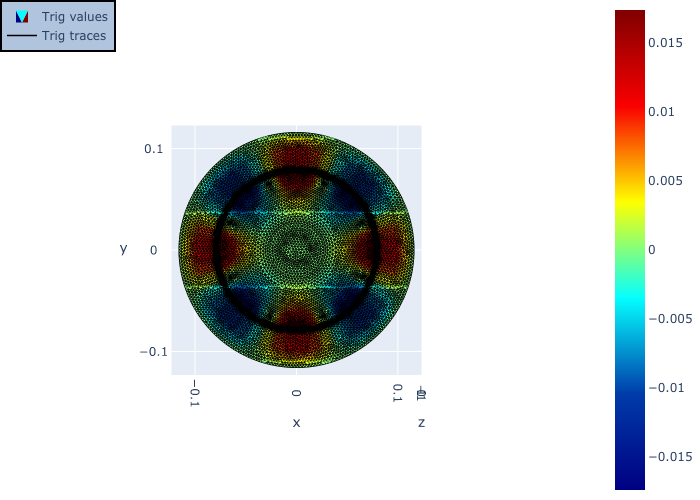

In [28]:
fig = MESH.pdesurf_hybrid(dict(trig = 'P1', quad = 'Q1', controls = 0), u[:MESH.np], u_height = 0)
fig.layout.scene.camera.projection.type = "orthographic"
fig.data[0].colorscale='Jet'
fig.show()

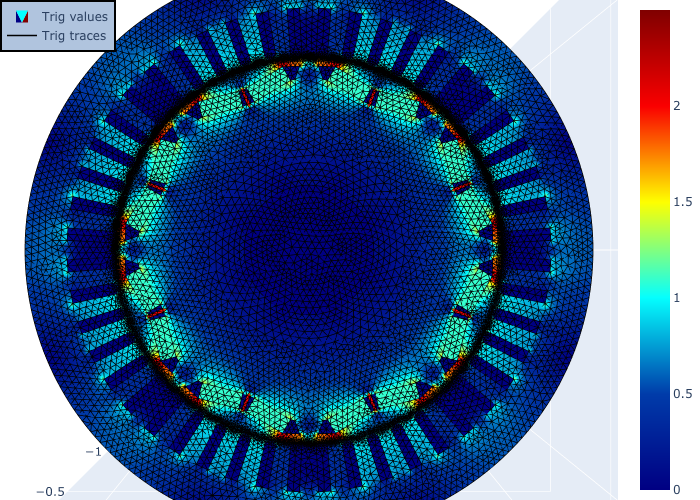

In [29]:
if dxpoly == 'P1':
    ux = dphix_H1_o1.T@u
    uy = dphiy_H1_o1.T@u
    norm_ux = np.sqrt(ux**2+uy**2)
    fig = MESH.pdesurf_hybrid(dict(trig = 'P1d', quad = 'Q1d', controls = 0), norm_ux, u_height = 0)
    fig.data[0].colorscale='Jet'

if dxpoly == 'P0':
    ux = dphix_H1_o0.T@u
    uy = dphiy_H1_o0.T@u
    norm_ux = np.sqrt(ux**2+uy**2)
    fig = MESH.pdesurf_hybrid(dict(trig = 'P0', quad = 'Q0', controls = 0), norm_ux, u_height = 0)
    fig.data[0].colorscale='Jet'

fig.show()